In [ ]:
import pandas as pd
import numpy as np
import spacy
import re
import string
from collections import defaultdict
import requests
import math
import string
# from myFunctions import processSentences, meanVector, cosineDistance
import statistics
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models.phrases import Phrases, Phraser
import gensim.downloader as api
from gensim.models import Word2Vec

# Process data

In [ ]:
data = pd.read_csv("../data/reddit_wsb.csv")
data2 = pd.read_csv("../data/r_wallstreetbets_posts.csv")

In [3]:
data.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [4]:
data2.head()

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,ll0n5k,Whats going on with PLTR?,1,Zaccko98,NaN,moderator,0.0,[],1613469192,https://www.reddit.com/r/wallstreetbets/commen...,2,False
1,ll0n4p,"Need explanations on Level 2 data for GME, why...",1,toutoucnc,210115:1:1,moderator,0.0,[],1613469189,https://www.reddit.com/r/wallstreetbets/commen...,2,False
2,ll0my2,XRT is being used as a laundry short machine,1,thabat,NaN,moderator,0.0,[],1613469166,https://www.reddit.com/r/wallstreetbets/commen...,2,False
3,ll0mxr,Airlines?,1,AsianTwink_,NaN,moderator,0.0,[],1613469165,https://www.reddit.com/r/wallstreetbets/commen...,2,False
4,ll0mx4,Buy TRXC 🚀,1,Oneverystreet8,NaN,moderator,0.0,[],1613469164,https://www.reddit.com/r/wallstreetbets/commen...,2,False


In [5]:
sentences_raw = []

for i in range(len(data)):
    body = data['body'][i]
    if type(body) == str:
        sentences_raw.extend(body.split('.'))
    
for i in range(len(data2)):
    title = data2['title'][i]
    if type(title) == str:
        sentences_raw.append(title)

In [6]:
def cleanString(s):

    s = s.lower()

    # remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    s = regrex_pattern.sub(r'',s)

    # remove non-alphabet characters
    myPunc = '!"#%&$()*+-./:;,<=>?@[\\]^_`{|}~'
    s = s.translate(s.maketrans(myPunc, ' '*len(myPunc)))
    s = s.translate(s.maketrans(string.digits, ' '*len(string.digits)))

    # clean up extra white-space
    s = re.sub('\s+',' ',s)
    return s.strip()

def findBigrams(corpus : list, min_count : int):

    corpusPhrased = []
    # this actually finds the bigrams
    phrases = Phrases(corpus, min_count = min_count, delimiter='_')

    for sent in corpus:
        phrased = phrases[sent]
        corpusPhrased.append(phrased)

    return corpusPhrased

def processSentences(sentences, minStringSize = 5, minTokenCount = 3, splitonPeriod = False, phraseMinCount = 25, bigrams=True, trigrams=True):

    # apply string cleaning
    sentences_clean = list(map(cleanString, sentences))

    # lets filter out any short strings, as they likely wont hold enough information.
    sentences_clean = list(filter(lambda x: len(x) > minStringSize, sentences_clean))

    # okay so now lets go ahead and tokenize our sentences into words.
    # were going to ignore any sentences with fewer than 3 words.

    sentences_tokenized = []

    for sentence in sentences_clean:

        # for some of the larger bodies of text we are first going to split on periods to get 'real' sentences.
        if splitonPeriod:
            sents_split = sentence.split('.')

            for sent in sents_split:
                tokens = sent.split(' ')
                # were only going to care about 3 or greater.
                if len(tokens) >= minTokenCount:

                    sentences_tokenized.append(tokens)

        # dont split on period.
        else:
            tokens = sentence.split(' ')
            if len(tokens) >= minTokenCount:
                sentences_tokenized.append(tokens)


    # Time to find Bigrams and Trigrams
    if bigrams:
        sentences_tokenized = findBigrams(sentences_tokenized, phraseMinCount)
    if trigrams:
        sentences_tokenized = findBigrams(sentences_tokenized, phraseMinCount)
    
#     lem = WordNetLemmatizer()
    for sent in sentences_tokenized:
        for i in range(len(sent)):
            if sent[i] == 'facebook':
                sent[i] = 'meta'
#             sent[i] = lem.lemmatize(sent[i])
    
    return sentences_tokenized

In [7]:
sentences_clean = processSentences(sentences_raw, minStringSize = 5, minTokenCount = 2, splitonPeriod = True, phraseMinCount = 25, bigrams=False, trigrams=False)

# Use data to train the model

In [8]:
text8 = api.load('text8')

# start with text8 as a base. 
model = Word2Vec(text8, min_count=25, window =2, sg = 1, vector_size=100)

model.build_vocab(sentences_clean, update=True)
model.train(sentences_clean,total_examples=len(sentences_clean), epochs = 10)

(122913779, 154887240)

# Use news data to train the model again

In [9]:
api_key = '633db6fb57df19.90772200'

In [10]:
def get_customized_news(stocks, start_date, end_date, n_news, api_key, offset = 0):
   
    
    info = defaultdict(list)
    for stock in stocks:
        url = f'https://eodhistoricaldata.com/api/news?api_token={api_key}&s={stock}&limit={n_news}&offset={offset}&from={start_date}&to={end_date}'
        news_json = requests.get(url).json()
        for i in range(len(news_json)):
            title = news_json[-i]['title']
            date = news_json[-i]['date']
            link = news_json[-i]['link']
            tag = news_json[-i]['tags']
            info['title'].append(title)
            info['date'].append(date)
            info['link'].append(link)
            info['tags'].append(tag)
            info['stock'].append(stock)
            
    return info

In [11]:
ticker = ['TSLA','AAPL','AMZN','GOOGL','EBAY','F','NVDA','AMD','FB','INTC']
info_2020 = get_customized_news(ticker, '2020-01-01', '2020-12-31',1000, api_key, 0)
info_2019 = get_customized_news(ticker, '2019-01-01', '2019-12-31',1000, api_key, 0)
info_2018 = get_customized_news(ticker, '2018-01-01', '2018-12-31',1000, api_key, 0)
info_2017 = get_customized_news(ticker, '2017-01-01', '2017-12-31',1000, api_key, 0)
info_2016 = get_customized_news(ticker, '2016-01-01', '2016-12-31',1000, api_key, 0)
info_2015 = get_customized_news(ticker, '2015-01-01', '2015-12-31',1000, api_key, 0)

In [12]:
news_2015 = pd.DataFrame(info_2015)
news_2016 = pd.DataFrame(info_2016)
news_2017 = pd.DataFrame(info_2017)
news_2018 = pd.DataFrame(info_2018)
news_2019 = pd.DataFrame(info_2019)
news_2020 = pd.DataFrame(info_2020)
news_2015.head()

,title,date,link,tags,stock
0,"Tesla Announces New Leadership in Finance, Sal...",2015-11-03T22:41:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA
1,Tesla Invites America to Join the Next Billion,2015-07-16T17:35:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA
2,Tesla Announces Release Date for Second Quarte...,2015-07-22T11:04:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA
3,Tesla Releases Second Quarter 2015 Financial R...,2015-08-05T20:43:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA
4,Tesla Announces $500 Million Common Stock Offe...,2015-08-13T11:08:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA


In [13]:
frame = [news_2015,news_2016,news_2017,news_2018,news_2019,news_2020]
news_1520 = pd.concat(frame).reset_index(drop=True9;n m)
news_1520.head()

,title,date,link,tags,stock
0,"Tesla Announces New Leadership in Finance, Sal...",2015-11-03T22:41:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA
1,Tesla Invites America to Join the Next Billion,2015-07-16T17:35:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA
2,Tesla Announces Release Date for Second Quarte...,2015-07-22T11:04:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA
3,Tesla Releases Second Quarter 2015 Financial R...,2015-08-05T20:43:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA
4,Tesla Announces $500 Million Common Stock Offe...,2015-08-13T11:08:00+00:00,https://www.globenewswire.com/news-release/201...,[TESLA MOTORS],TSLA


In [14]:
news_raw = []

for i in range(len(news_1520)):
    title = news_1520['title'][i]
    if type(title) == str:
        news_raw.append(title)
        
news_clean = processSentences(news_raw, minStringSize = 5, minTokenCount = 2, splitonPeriod = True, phraseMinCount = 25, bigrams=False, trigrams=False)
news_clean[0]

['tesla',
 'announces',
 'new',
 'leadership',
 'in',
 'finance',
 'sales',
 'service']

In [15]:
model.build_vocab(news_clean, update=True)
model.train(news_clean,total_examples=len(news_clean), epochs = 10)

(246572, 352500)

In [16]:
word_vectors = model.wv
word_vectors.most_similar(positive=['meta'])

[('paypal', 0.7412407398223877),
 ('intel', 0.7288313508033752),
 ('fb', 0.7231813073158264),
 ('alphabet', 0.7215366363525391),
 ('notifies', 0.6904330849647522),
 ('aapl', 0.6865194439888),
 ('inc', 0.6837145686149597),
 ('starbucks', 0.6787220239639282),
 ('thestreet', 0.6653465628623962),
 ('qualcomm', 0.663209855556488)]

# Extract the company entities

In [17]:
KEY_TYPES = (str, int, np.integer)

def meanVector(keyedVectors, positive=list(), negative=list()):

    # remove any words that arent in the vocabulary
    positive = list(filter(lambda x: (x in keyedVectors), positive))
    negative = list(filter(lambda x: (x in keyedVectors), negative))

    positive = [
            (item, 1.0) if isinstance(item, KEY_TYPES + (np.ndarray,))
            else item for item in positive
            ]
    negative = [
            (item, -1.0) if isinstance(item, KEY_TYPES + (np.ndarray,))
            else item for item in negative
            ]

    # compute the weighted average of all keys
    all_keys, mean = set(), []
    for key, weight in positive + negative:
        if isinstance(key, np.ndarray):
            mean.append(weight * key)
        else:
            mean.append(weight * keyedVectors.get_vector(key, norm=True))
            if keyedVectors.has_index_for(key):
                all_keys.add(keyedVectors.get_index(key))
        if not mean:
            raise ValueError("cannot compute similarity with no input")

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

    return mean

def extractCompanies(keyedVectors, sentences_processed, threshold, myVector):
    
    sentences, extracted = [], []
    
    for sentence in sentences_processed:
        
        found = []
        
        for token in sentence:
        
            try:
                
                if cosineDistance(keyedVectors[token], myVector) >= threshold:
                    found.append(token)
            
            except KeyError:
                pass
        

        sentences.append(sentence)
        extracted.append(list(set(found)))
        
    return pd.DataFrame({'sent':sentences, 'extracted':extracted})

def cosineDistance(v1, v2):
    # matutils.unitvec scales the vectors
    return np.dot(gensim.matutils.unitvec(v1), gensim.matutils.unitvec(v2))

In [18]:
info_2021 = get_customized_news(ticker, '2021-01-01', '2021-12-31',1000, api_key, 0)
info_2022_1 = get_customized_news(ticker, '2022-01-01', '2022-06-30',1000, api_key, 0)
ticker = ['TSLA','AAPL','AMZN','GOOGL','EBAY','F','NVDA','AMD','META','INTC']
info_2022_2 = get_customized_news(ticker, '2022-07-01', '2022-10-20',1000, api_key, 0)
news_2021 = pd.DataFrame(info_2021)
news_2022_1 = pd.DataFrame(info_2022_1)
news_2022_2 = pd.DataFrame(info_2022_2)
frame = [news_2021,news_2022_1,news_2022_2]
news_2122 = pd.concat(frame).reset_index(drop=True)
len(news_2122)

27443

In [19]:
news_raw = []

for i in range(len(news_2122)):
    title = news_2122['title'][i]
    if type(title) == str:
        news_raw.append(title)

myVec = meanVector(word_vectors, positive=['tesla', 'apple','amazon','google', 'ebay','ford', 'nvidia','amd','meta','intel'], 
                negative=['with','in','partnership','elon','musk','chipmaker'])     

news_clean_2122 = processSentences(news_raw, minStringSize = 5, minTokenCount = 2, splitonPeriod = True, phraseMinCount = 25, bigrams=False, trigrams=False)
print(len(news_clean_2122))
result_2122 = extractCompanies(word_vectors, news_clean_2122, 0.6, myVec)
result_2122

27443


,sent,extracted
0,"[dow, jones, futures, tesla, nio, xpeng, ev, d...",[]
1,"[chip, stocks, to, buy, as, the, supply, crunc...",[]
2,"[investors, unfazed, as, microsoft, ceo, nadel...",[microsoft]
3,"[why, nio, stock, plunged, today]",[]
4,"[big, money, buys, tesla, again, and, again]",[]
...,...,...
27438,"[intel, is, in, trouble, as, pc, demand, dlumps]",[intel]
27439,"[intel, is, in, trouble, as, pc, demand, slumps]",[intel]
27440,"[media, alert, intel, at, kubecon, cloudnative...",[intel]
27441,"[dividend, paying, tech, stocks, with, yields,...",[]


# Extract relationship of collaboration and competition

In [20]:
collaborate = ['deal','cooperate', 'ally', 'comnbine','collaborate','collaboration', 'together', 'partner'
               ,'coordinate', 'engage', 'partnership','partnerships','agree','tie','associate','support']
compete = ['against', 'vie', 'contend', 'fight', 'contest', 'dispute', 'battle','accuse','compete','challenge','vs'
           ,'rival','rivals','campaign','competition','sues']
col_string = "(?:"+"|".join(collaborate)+")"
com_string = "(?:"+"|".join(compete)+")"
words_col = re.compile(rf"\b{col_string}\b")
words_com = re.compile(rf"\b{com_string}\b")

In [21]:
rel = []
for i in range(len(result_2122)):
    if len(result_2122['extracted'][i]) > 1 and words_col.search(news_2122['title'][i].lower()):
        rel.append('collaborate')
    elif len(result_2122['extracted'][i]) > 1 and words_com.search(news_2122['title'][i].lower()):
        rel.append('compete')
    else:
        rel.append('NA')
result_2122['Relation'] = rel
result_2122

,sent,extracted,Relation
0,"[dow, jones, futures, tesla, nio, xpeng, ev, d...",[],NA
1,"[chip, stocks, to, buy, as, the, supply, crunc...",[],NA
2,"[investors, unfazed, as, microsoft, ceo, nadel...",[microsoft],NA
3,"[why, nio, stock, plunged, today]",[],NA
4,"[big, money, buys, tesla, again, and, again]",[],NA
...,...,...,...
27438,"[intel, is, in, trouble, as, pc, demand, dlumps]",[intel],NA
27439,"[intel, is, in, trouble, as, pc, demand, slumps]",[intel],NA
27440,"[media, alert, intel, at, kubecon, cloudnative...",[intel],NA
27441,"[dividend, paying, tech, stocks, with, yields,...",[],NA


In [42]:
result_2122.loc[result_2122['Relation'] == 'collaborate'].head()

,sent,extracted,Relation
448,"[dow, falls, as, apple, microsoft, weigh, nasd...","[microsoft, apple]",collaborate
1634,"[dow, falls, as, apple, microsoft, weigh, nasd...","[microsoft, apple]",collaborate
3301,"[australian, mining, billionaire, to, help, pu...","[google, meta]",collaborate
3302,"[australian, mining, billionaire, to, help, pu...","[google, meta]",collaborate
3303,"[update, australian, billionaire, to, help, pu...","[google, meta]",collaborate


In [23]:
result_2122.loc[result_2122['Relation'] == 'compete']

,sent,extracted,Relation
10,"[dow, jones, futures, market, rally, skids, on...","[salesforce, zscaler]",compete
532,"[dow, jones, futures, rise, with, apple, amd, ...","[nvidia, amd, adobe, apple]",compete
1222,"[dow, jones, futures, market, rally, skids, on...","[salesforce, zscaler]",compete
1394,"[tech, stocks, roundup, apple, meta, vs, sexti...","[apple, meta]",compete
1766,"[epic's, sweeney, on, battle, with, apple, goo...","[google, apple]",compete
...,...,...,...
26957,"[better, buy, amd, vs, micron, technology]","[amd, micron]",compete
27058,"[chipmakers, amd, releases, a, new, weapon, ag...","[intel, amd]",compete
27109,"[better, semiconductor, stock, amd, vs, nvidia]","[amd, nvidia]",compete
27133,"[better, bear, market, buy, nvidia, vs, intel]","[intel, nvidia]",compete


# KG for collaboration and competition

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [25]:
df_col = result_2122.loc[result_2122['Relation'] == 'collaborate'].reset_index(drop=True)
df_com = result_2122.loc[result_2122['Relation'] == 'compete'].reset_index(drop=True)

In [30]:
for i in range(len(df_col)):
    for j in range(len(df_col['extracted'][i])):
        if "’s" in  df_col['extracted'][i][j]:
            df_col['extracted'][i][j] = df_col['extracted'][i][j].replace("’s","")
        if "’s" in  df_col['extracted'][i][j]:
            df_com['extracted'][i][j] = df_com['extracted'][i][j].replace("’s","")
            
entity_col = []
for i in range(len(df_col)):
    if len(df_col['extracted'][i]) <= 2:
        if df_col['extracted'][i] not in entity_col:
            entity_col.append(df_col['extracted'][i])
    else:
        for j in range(len(df_col['extracted'][i])):
            if j+1 < len(df_col['extracted'][i]):
                for k in range(j+1,len(df_col['extracted'][i])):
                    temp = [df_col['extracted'][i][j],df_col['extracted'][i][k]]
                    if temp not in entity_col:
                        entity_col.append(temp)

source_col = [i[0] for i in entity_col]
target_col = [i[1] for i in entity_col]
edge_col = ['collaborate' for _ in range(len(entity_col))]
kg_col = pd.DataFrame({'source':source_col, 'target':target_col, 'edge':edge_col})

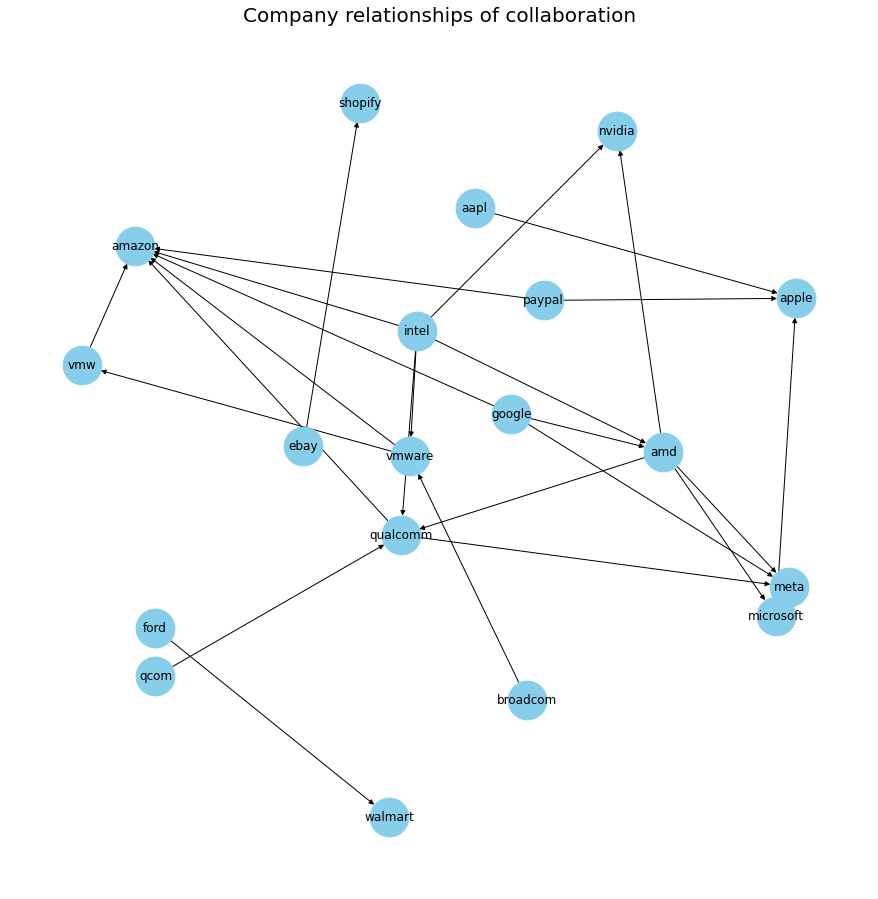

In [36]:
G=nx.from_pandas_edgelist(kg_col, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 1) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('Company relationships of collaboration',fontdict = {'fontsize' : 20})
plt.show()

In [38]:
entity_com = []
for i in range(len(df_com)):
    if len(df_com['extracted'][i]) <= 2:
        if df_com['extracted'][i] not in entity_com:
            entity_com.append(df_com['extracted'][i])
    else:
        for j in range(len(df_com['extracted'][i])):
            if j+1 < len(df_com['extracted'][i]):
                for k in range(j+1,len(df_com['extracted'][i])):
                    temp = [df_com['extracted'][i][j],df_com['extracted'][i][k]]
                    if temp not in entity_com:
                        entity_com.append(temp)

source_com = [i[0] for i in entity_com]
target_com = [i[1] for i in entity_com]
edge_com = ['compete' for _ in range(len(entity_com))]
kg_com = pd.DataFrame({'source':source_com, 'target':target_com, 'edge':edge_com})

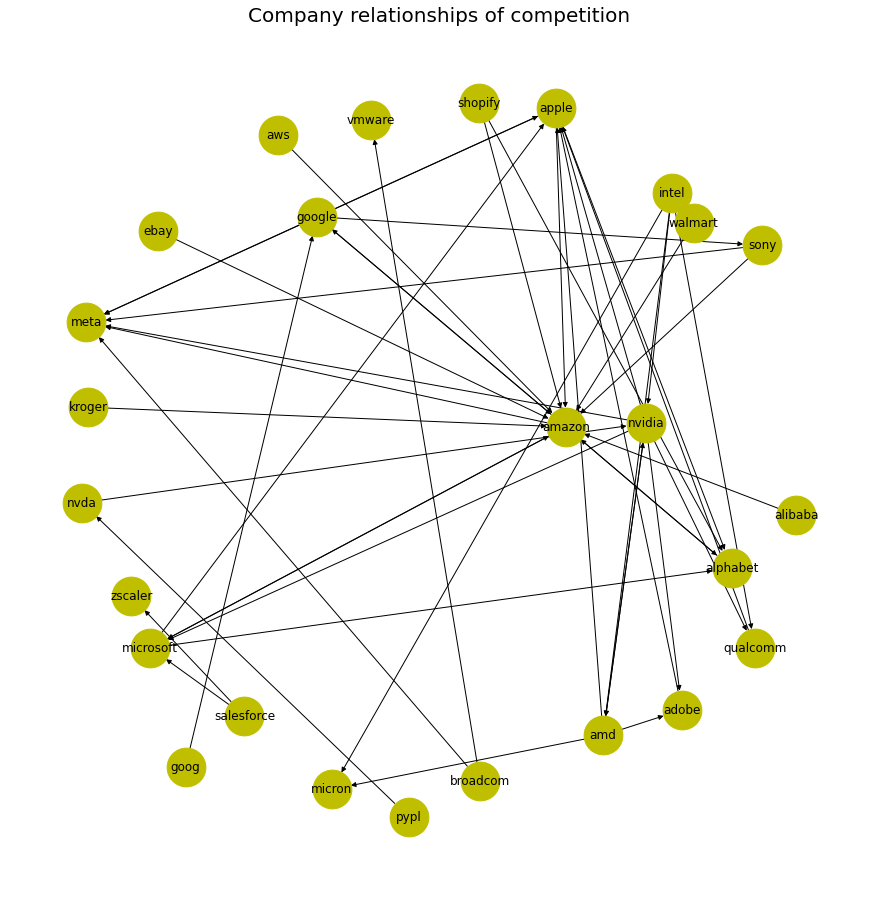

In [41]:
G=nx.from_pandas_edgelist(kg_com, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 2) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='y', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('Company relationships of competition',fontdict = {'fontsize' : 20})
plt.show()

# Data processing of owned by and owner of 

In [99]:
amazon = pd.read_csv("../data/Amazon.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
amd = pd.read_csv("../data/AMD.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
apple = pd.read_csv("../data/Apple.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
ebay = pd.read_csv("../data/ebay.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
ford = pd.read_csv("../data/Ford.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
google = pd.read_csv("../data/Google.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
intel = pd.read_csv("../data/Intel.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
meta = pd.read_csv("../data/Meta.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
nvidia = pd.read_csv("../data/Nvidia.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)
tesla = pd.read_csv("../data/Tesla.csv",usecols=range(4),header = None,names=["owned by", "proportion", "has subsidiary", "owner of"], skiprows=1)

In [121]:
company = [amazon,amd,apple,ebay,ford,google,intel,meta,nvidia,tesla]
cn = ['Amazon','AMD','Apple','Ebay','Ford','Google','Intel','Meta','Nvidia','Tesla']
for i,c in enumerate(company):
    name = [cn[i] for _ in range(len(c))]
    c['company'] = name
df_company = pd.concat(company).reset_index(drop=True)
df_company = df_company.dropna(thresh=2).reset_index(drop=True)
df_company.head()

,owned by,proportion,has subsidiary,owner of,company
0,Jeff Bezos,0.160,Zoox,Amazon CloudFront,Amazon
1,The Vanguard Group,0.062,Goodreads,Woot,Amazon
2,BlackRock,0.052,Amazon Logistics,Whole Foods Market,Amazon
3,NaN,NaN,Amazon Lab126,Goodreads,Amazon
4,NaN,NaN,AVCREC,Amazon S3,Amazon


# KG relationship

In [149]:
source_by = []
target_by = []
edge_by = []
for i in range(len(df_company)):
    if not pd.isnull(df_company['owned by'][i]):
        source_by.append(df_company['owned by'][i])
        target_by.append(df_company['company'][i])
        edge_by.append('owned by')
kg_by = pd.DataFrame({'source':source_by, 'target':target_by, 'edge':edge_by})

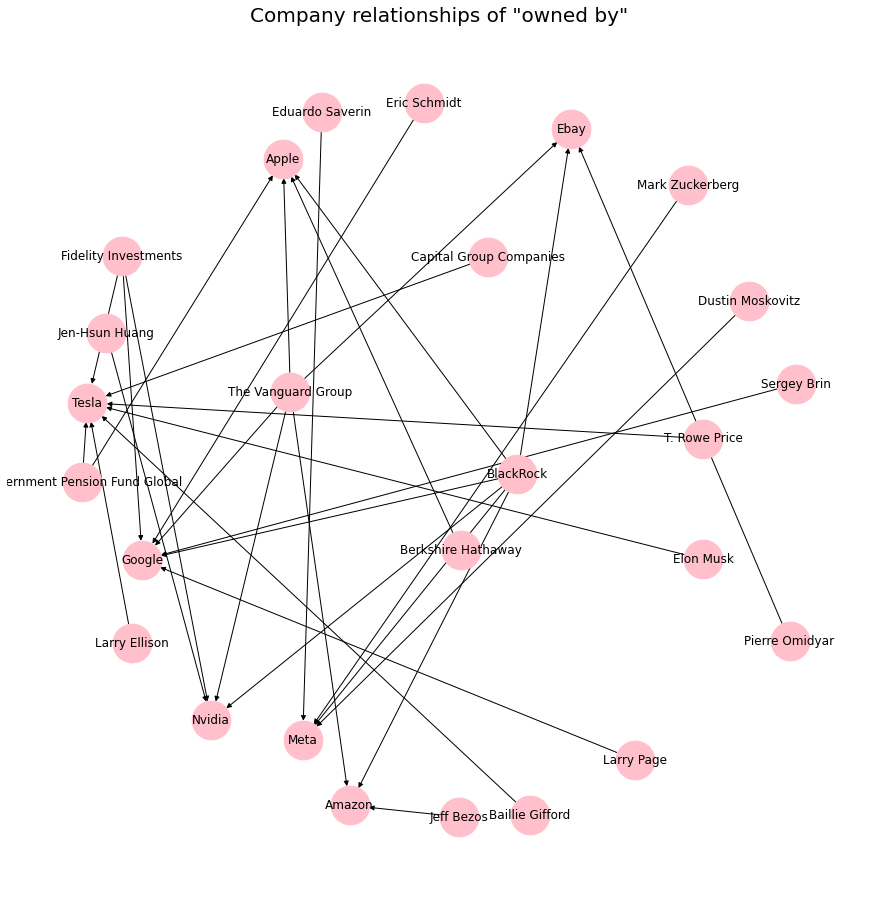

In [151]:
G=nx.from_pandas_edgelist(kg_by, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 1.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='pink', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('Company relationships of "owned by"',fontdict = {'fontsize' : 20})
plt.show()

In [158]:
source_sub = []
target_sub = []
edge_sub = []
for i in range(len(df_company)):
    if not pd.isnull(df_company['has subsidiary'][i]):
        source_sub.append(df_company['has subsidiary'][i])
        target_sub.append(df_company['company'][i])
        edge_sub.append('has subsidiary')
kg_sub = pd.DataFrame({'source':source_sub, 'target':target_sub, 'edge':edge_sub})

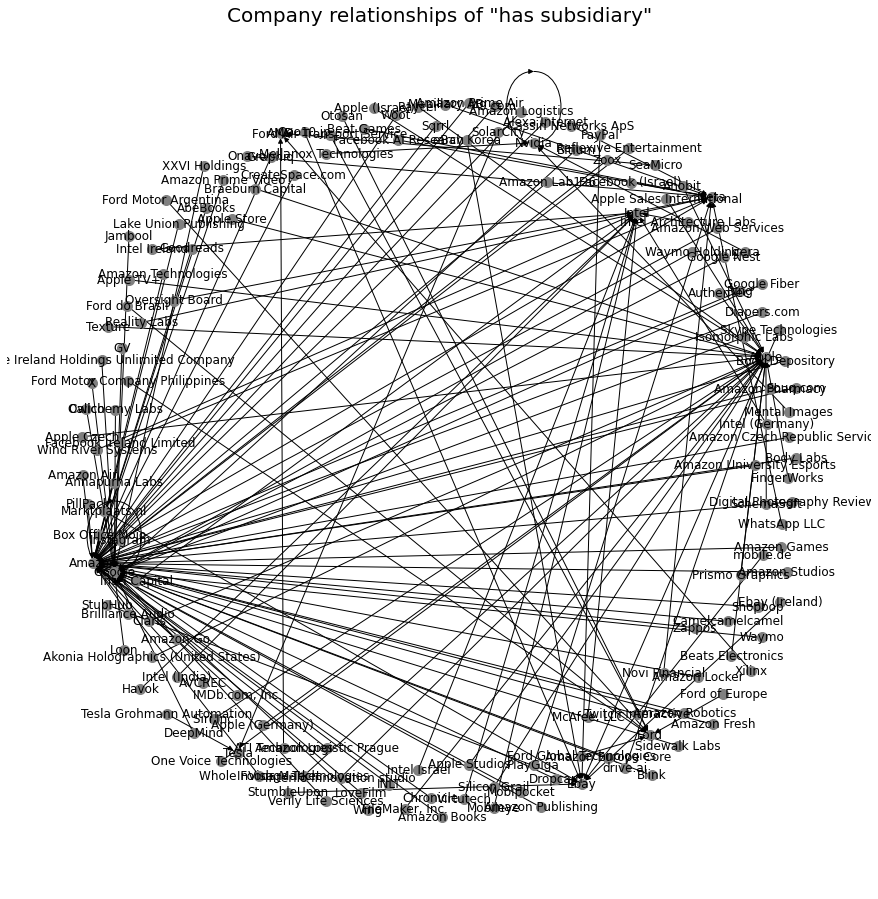

In [159]:
G=nx.from_pandas_edgelist(kg_sub, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 3) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='grey', node_size=100, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('Company relationships of "has subsidiary"',fontdict = {'fontsize' : 20})
plt.show()

In [160]:
source_of = []
target_of = []
edge_of = []
for i in range(len(df_company)):
    if not pd.isnull(df_company['owner of'][i]):
        source_of.append(df_company['owner of'][i])
        target_of.append(df_company['company'][i])
        edge_of.append('owner of')
kg_of = pd.DataFrame({'source':source_of, 'target':target_of, 'edge':edge_of})

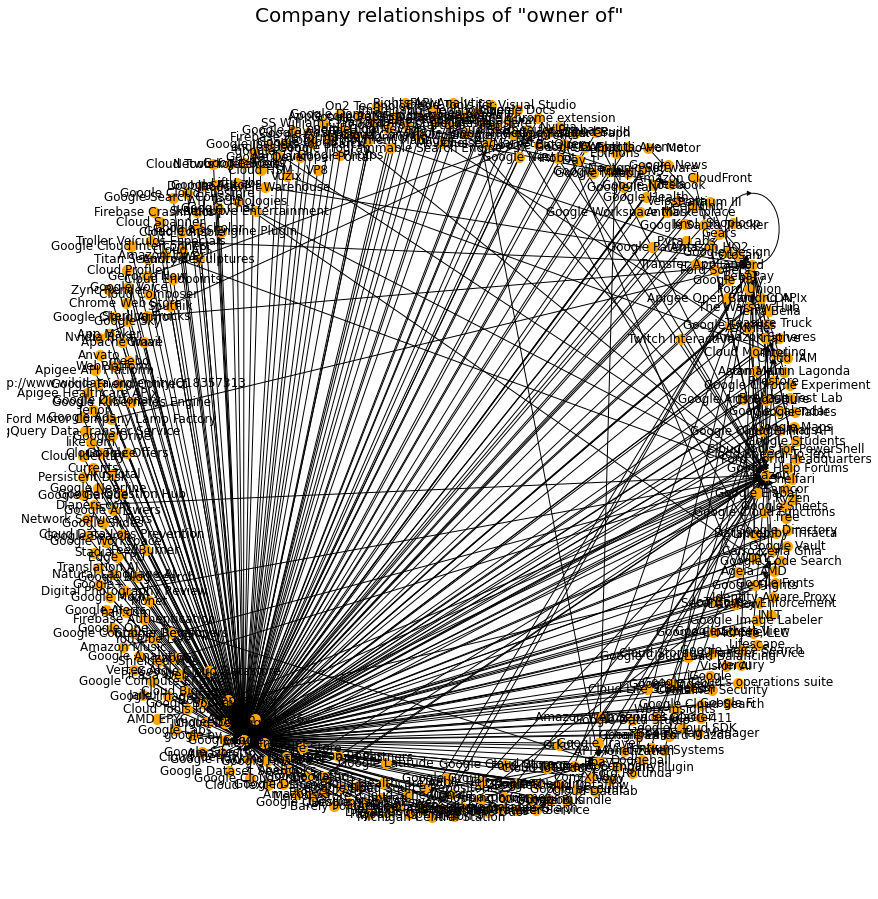

In [165]:
G=nx.from_pandas_edgelist(kg_of, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='orange', node_size=100, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('Company relationships of "owner of"',fontdict = {'fontsize' : 20})
plt.show()